In [1]:
import os, sys
sys.path.append('../CommonUtils/')
import CommonUtils as cu
sys.path.append(os.environ["JUPYROOT"]) 
import RUtils as ru
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
from scipy import optimize

dataXY, n_binsXY, dBinsXY = ru.hist2np(file_path="DATA/VLEDM.root", hist_path="AllStationsNoTQ/VertexExt/t>0/0<p<3600/thetay_vs_time_modg2")
df_data=cu.Profile(dataXY[0], dataXY[1], False, nbins=15, xmin=np.min(dataXY[0]),xmax=np.max(dataXY[0]), full_y=True, only_binned=True)

Welcome to JupyROOT 6.18/04
RUtils::hist2np Opening AllStationsNoTQ/VertexExt/t>0/0<p<3600/thetay_vs_time_modg2 in DATA/VLEDM.root
RUtils::hist2np Opened Name: thetay_vs_time_modg2 Title:   NbinsX: 300 <class 'float'> with 5276210 entries (exc. over/underflows)


In [2]:
N_points=len(df_data)
df_data

,index,bincenters,y,xerr,yerr
0,1,0.152301,"[-0.09845000000000001, -0.09835, -0.0976500000...",0.145026,0.000043
1,2,0.442353,"[-0.09975, -0.09945000000000001, -0.0994500000...",0.145026,0.000042
2,3,0.732404,"[-0.09915000000000002, -0.09905000000000001, -...",0.145026,0.000041
3,4,1.022456,"[-0.09935000000000001, -0.09915000000000002, -...",0.145026,0.000039
4,5,1.312507,"[-0.09995000000000001, -0.09995000000000001, -...",0.145026,0.000037
5,6,1.602559,"[-0.09955000000000001, -0.09805000000000001, -...",0.145026,0.000036
6,7,1.892610,"[-0.09995000000000001, -0.09935000000000001, -...",0.145026,0.000035
7,8,2.182661,"[-0.09995000000000001, -0.09965000000000002, -...",0.145026,0.000035
8,9,2.472713,"[-0.09995000000000001, -0.09985000000000001, -...",0.145026,0.000036
9,10,2.762764,"[-0.09895000000000001, -0.09875, -0.0986500000...",0.145026,0.000037


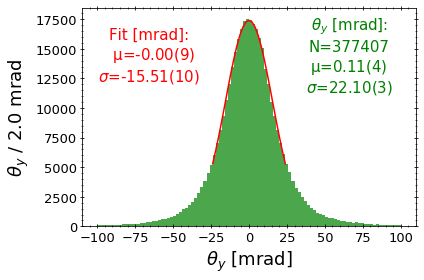

In [5]:
# fit for a range of data 
n_bins=25
y_min, y_max=-25, +25

# all data y_hist, range is y 
y_hist=df_data['y'][5]*1e3 # rad -> mrad 
y  = y_hist[np.logical_and(y_hist >= y_min, y_hist <= y_max)]

#bin the data in range 
hist, bin_edges = np.histogram(y, bins=n_bins, density=False)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
bin_width=bin_edges[1]-bin_edges[0] 
#find the right number of bins for. all data
n_bins_hist=int( (np.max(y_hist)-np.min(y_hist))/bin_width )  

def gauss(x, *p): 
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

y_err=np.sqrt(hist)

# fit in range 
p0=[1, 1, 1]
par, pcov = optimize.curve_fit(gauss, bin_centres, hist, sigma=y_err, p0=p0, absolute_sigma=False, method='trf')
par_e = np.sqrt(np.diag(pcov))

#plot and stats + legend 
legend_fit=cu.legend4(par[1], par_e[1], par[2], par_e[2], prec=2)
ax, legend = cu.plotHist(y_hist, n_bins=n_bins_hist, prec=2)
ax.plot(bin_centres, gauss(bin_centres, *par), color="red", label='Fit')
cu.textL(ax, 0.8, 0.78, r"$\theta_y$ [mrad]:"+"\n"+str(legend), font_size=15)
cu.textL(ax, 0.2, 0.78, "Fit [mrad]:"+"\n"+str(legend_fit), font_size=15, color="red")
ax.set_xlabel(r"$\theta_y$ [mrad]", fontsize=18)
ax.set_ylabel(r"$\theta_y$ / "+str(round(bin_width))+" mrad", fontsize=18)
plt.tight_layout()
plt.savefig("fig/Gaus_fit.png", dpi=300)





In [8]:
def chi2_ndf(x, y, y_err, func, pars):
    '''
    Calcualte chi2
    # TODO generalise for any N of parameters
    '''    
    chi2=0
    print(len(x), len(y), len(y_err))
    for i in range(0, len(x)): # TODO fix dataframes to start from  0!! 
        r = y[i] - func(x[i], *pars)  
        chi2+=(r)**2/y_err[i]**2
    ndf = len(x) - len(pars)
    return chi2/ndf

y_err=np.sqrt(hist)
print(hist)
print(y_err)
chi2ndf= chi2_ndf(bin_centres, hist, y_err, gauss, par)
print(chi2ndf)

[ 5557  6495  7619  8572 10142 11256 12642 14288 15351 16182 17125 17576
 17424 17298 16953 16254 15627 14019 12724 11248  9979  8587  7654  6535
  5618]
[ 74.54528825  80.59156283  87.28688332  92.58509599 100.70749724
 106.09429768 112.43664883 119.53242238 123.89915254 127.20849028
 130.86252328 132.57450735 132.         131.5218613  130.20368658
 127.49117617 125.00799974 118.40185809 112.80070922 106.05658867
  99.89494482  92.66606714  87.48714191  80.83934686  74.95331881]
25 25 25
5.730978171462966
